In [144]:
import csv

import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.utils import to_categorical

In [145]:
train_df = pd.read_csv('/hdd/datasets/sarcasm/train-balanced-sarcasm.csv')

In [146]:
train_df = train_df.drop(train_df.columns[[2,3,4,5,6,7,8,9]], axis=1)
print(train_df.head())

comments = train_df['comment'].tolist()
comments = [i.split(' ') for i in comments if isinstance(i, str)]

   label                                            comment
0      0                                         NC and NH.
1      0  You do know west teams play against west teams...
2      0  They were underdogs earlier today, but since G...
3      0  This meme isn't funny none of the "new york ni...
4      0                    I could use one of those tools.


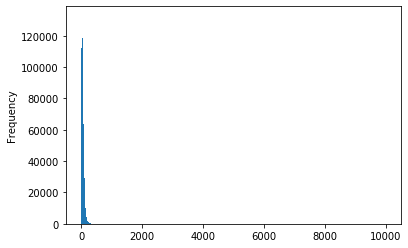

In [147]:
train_df['length'] = train_df['comment'].str.len()
train_df = train_df.dropna()

ax = train_df['length'].plot.hist(bins=1000)

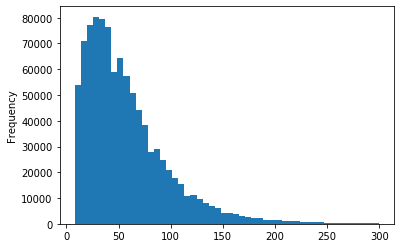

In [148]:
train_df = train_df[train_df['length'] <= 300]
train_df = train_df[train_df['length'] >= 8]
ax = train_df['length'].plot.hist(bins=50)

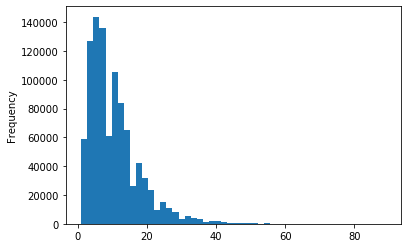

In [149]:
train_df['words'] = train_df['comment'].str.split().apply(len)
ax = train_df['words'].plot.hist(bins=50)
train_df = train_df[train_df['words'] >= 2]
train_df = train_df[train_df['words'] <= 30]

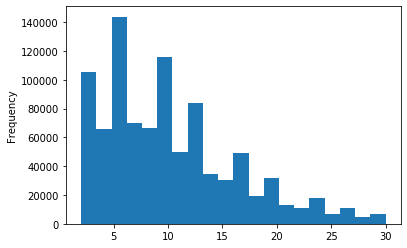

In [150]:
ax = train_df['words'].plot.hist(bins=20)

In [151]:
print(train_df.sort_index(by=['length'], ascending=False))
print(train_df['label'].value_counts())

        label                                            comment  length  \
394848      0  20160128_1653_france-F09_AMX_50_120_02_malinov...   296.0   
106279      0  Very good, I too have been playing with speech...   274.0   
270653      0  Home| |vs| |Away --:|--|--|--|-- Slovakia|0|-|...   272.0   
437159      1  BOY OH BOY I CAN'T WAIT FOR MEDIA DAY NOW WOOO...   269.0   
612383      1  Well excuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu...   266.0   
...       ...                                                ...     ...   
967289      1                                           mine was     8.0   
16885       0                                           Choon m8     8.0   
53196       1                                           100% F2P     8.0   
716880      0                                           not sure     8.0   
833069      0                                           oh lawdy     8.0   

        words  
394848      6  
106279     27  
270653     18  
437159     13  
612383 

/opt/anaconda/miniconda3/envs/caispp-tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


In [152]:
comments = train_df['comment'].tolist()
comments = [i.split(' ') for i in comments if isinstance(i, str)]

In [153]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(comments)

tokens = tokenizer.texts_to_sequences(comments)
print(comments[:2])
print(tokens[:2])

[['NC', 'and', 'NH.'], ['You', 'do', 'know', 'west', 'teams', 'play', 'against', 'west', 'teams', 'more', 'than', 'east', 'teams', 'right?']]
[[6365, 6], [5, 48, 66, 1194, 750, 166, 236, 1194, 750, 54, 75, 1332, 750, 188]]


In [154]:
lengths = [len(x) for x in comments]
print(max(lengths))

30


In [155]:
MAX_SEQUENCE_LENGTH = 30
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = np.array(pad_sequences(tokens, maxlen=MAX_SEQUENCE_LENGTH))

Found 382313 unique tokens.


In [156]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = train_df['label'].values[indices]
labels = to_categorical(np.asarray(labels))
num_validation_samples = int(0.3 * data.shape[0])

In [157]:
x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

print('Number of entries in each category:')
print("Training:\n",y_train.sum(axis=0))
print("Validation:\n",y_val.sum(axis=0))

Number of entries in each category:
Training:
 [317676. 339323.]
Validation:
 [136114. 145456.]


In [171]:
EMBEDDING_DIM = 30

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [172]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32') # 1000
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 3, activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedded_sequences)
l_cov2= Conv1D(128, 3, activation='relu',kernel_regularizer=regularizers.l2(0.01))(l_cov1)
l_pool1 = MaxPooling1D(3)(l_cov2)
#l_drop1 = Dropout(0.2)(l_pool1)
l_cov3 = Conv1D(128, 3, activation='relu',kernel_regularizer=regularizers.l2(0.01))(l_pool1)
l_pool4 = MaxPooling1D(6)(l_cov3) # global max pooling
l_flat = Flatten()(l_pool4)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(2, activation='sigmoid')(l_dense)

In [173]:
model = Model(sequence_input, preds)
adadelta = optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0)
model.compile(loss='binary_crossentropy',
              optimizer=adadelta,
              metrics=['acc'])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 30, 30)            11469420  
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 28, 128)           11648     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 26, 128)           49280     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 8, 128)            0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 6, 128)            49280     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 1, 128)            0   

In [174]:
def step_cyclic(epoch):
    try:
        if epoch%11==0:
            return float(2)
        elif epoch%3==0:
            return float(1.1)
        elif epoch%7==0:
            return float(0.6)
        else:
            return float(1.0)
    except:
        return float(1.0)
        
model_checkpoints = callbacks.ModelCheckpoint("checkpoints", monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
lr_schedule = callbacks.LearningRateScheduler(step_cyclic)

W1125 19:10:44.175204 139627224778496 callbacks.py:875] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


In [ ]:
print("Training Progress:")
model.fit(x_train, y_train, validation_data=(x_val, y_val),
          epochs=100, batch_size=128,
          callbacks=[model_checkpoints, lr_schedule])

Training Progress:
Train on 656999 samples, validate on 281570 samples
Epoch 1/100
656999/656999 [==============================] - 14s 21us/sample - loss: 0.6926 - acc: 0.5165 - val_loss: 0.6927 - val_acc: 0.5166
Epoch 2/100
656999/656999 [==============================] - 14s 21us/sample - loss: 0.6926 - acc: 0.5165 - val_loss: 0.6927 - val_acc: 0.5166
Epoch 3/100
656999/656999 [==============================] - 14s 21us/sample - loss: 0.6926 - acc: 0.5165 - val_loss: 0.6926 - val_acc: 0.5166
Epoch 4/100
569088/656999 [========================>.....] - ETA: 1s - loss: 0.6926 - acc: 0.5167